In [2]:
from rdkit import Chem
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*')   

# Path to your SDF file
sdf_file = 'data/combined_mols_0_to_1000000.sdf'

# Create an SDMolSupplier object to read the SDF file
supplier = Chem.SDMolSupplier(sdf_file)

def is_valid_molecule(mol):
    """Check if all hydrogen atoms have exactly one bond."""
    total = 0
    for atom in mol.GetAtoms():
        if atom.GetSymbol() == 'H':
            total += 1
            if atom.GetDegree() != 1:
                return False
        if atom.GetSymbol() != 'H' and atom.GetDegree() == 1:
            return False
    return total > 1

molecule_list = []

# Iterate through each molecule in the SDF file
total_printed = 0
for index, mol in enumerate(supplier):
    if index % 100000 == 0:
        print(f'{index} / {len(supplier)}')
    
    if mol is not None and is_valid_molecule(mol):  # Check if the molecule is successfully read
        hydrogen_atoms_info = []
        other_atoms_info = []
        
        conf = mol.GetConformer()
        for atom in mol.GetAtoms():
            pos = conf.GetAtomPosition(atom.GetIdx())  # Get current atom position
            if atom.GetSymbol() == 'H':
                # For hydrogen atoms, find the atoms they are connected to
                for neighbor in atom.GetNeighbors():
                    neighbor_pos = conf.GetAtomPosition(neighbor.GetIdx())
                    hydrogen_atoms_info.append({
                        "H_position": (pos.x, pos.y, pos.z),
                        "connected_atom_type": neighbor.GetSymbol(),
                        "connected_atom_position": (neighbor_pos.x, neighbor_pos.y, neighbor_pos.z)
                    })
            else:
                # For other atoms, simply record their position
                other_atoms_info.append({
                    "atom_type": atom.GetSymbol(),
                    "position": (pos.x, pos.y, pos.z)
                })
                
        molecule_list.append({
            'H': hydrogen_atoms_info,
            'Other': other_atoms_info
        })
        
        print(hydrogen_atoms_info)


0 / 1000000
100000 / 1000000
[{'H_position': (2.4848, 1.9546, -0.1699), 'connected_atom_type': 'N', 'connected_atom_position': (3.1422, 1.1633, -0.1779)}, {'H_position': (6.0285, -2.1335, -1.8783), 'connected_atom_type': 'N', 'connected_atom_position': (5.7881, -2.898, -1.2329)}]
200000 / 1000000
[{'H_position': (3.3488, 3.1978, -1.6072), 'connected_atom_type': 'N', 'connected_atom_position': (2.6032, 3.6429, -1.0689)}, {'H_position': (-2.2282, 4.3897, 1.861), 'connected_atom_type': 'N', 'connected_atom_position': (-1.4752, 3.933, 1.3427)}]
300000 / 1000000
[{'H_position': (-0.1023, -0.3474, -0.3552), 'connected_atom_type': 'C', 'connected_atom_position': (0.8429, -0.0252, 0.0659)}, {'H_position': (3.2812, -0.8964, -1.0761), 'connected_atom_type': 'Si', 'connected_atom_position': (2.5468, -0.087, -0.015)}]
[{'H_position': (2.7244, 0.3878, -2.0758), 'connected_atom_type': 'N', 'connected_atom_position': (3.4981, 0.367, -1.4107)}, {'H_position': (4.9185, -3.3791, 0.7986), 'connected_atom

In [3]:
import numpy as np
import numpy.linalg as la

precision = np.float64

def molecule_to_np(hydrogen_list):
    n = len(hydrogen_list)
    
    h_q = np.zeros((3, n), dtype=precision)
    h_p = np.zeros((3, n), dtype=precision)# + 0.01*np.random.rand(3, n)
    n_q = np.zeros((3, n), dtype=precision)
    h_l = np.zeros(n)
    h_m = np.zeros(n)
    
    for i, atom in enumerate(hydrogen_list):
        h_q[:, i] = np.array(atom['H_position'], dtype=precision)
        n_q[:, i] = np.array(atom['connected_atom_position'], dtype=precision)
        h_l[i] = np.linalg.norm(h_q[:, i] - n_q[:, i])
        h_m[i] = 0.1
        
        # h_q[:, i] = h_q[:, i] + 1*np.random.rand(3)
        
        
    # print(h_q, '\n', h_p, '\n', n_q)
    return h_q, h_p, n_q, h_l, h_m

h_q, h_p, n_q, h_l, h_m = molecule_to_np(molecule_list[10]['H'])

In [4]:
# Constants
k_spr = 10
eps = 0.01
sigma = 3

def kinetic_energy(h_p, h_m):
    ke = np.sum(np.sum(h_p**2, axis=0) / (2 * h_m))  
    return ke

def potential_energy(h_q, n_q, h_l, f_c, f_i):
    energy = 0
    k = h_q.shape[1]  # Number of particles
    for i in range(k):
        for j in range(i + 1, k):
            r_ij = np.linalg.norm(h_q[:, j] - h_q[:, i])
            energy += f_c(r_ij)
        r_i = np.linalg.norm(n_q[:, i] - h_q[:, i])
        l = h_l[i]
        energy += f_i(r_i, l)
    return energy

def v_t(q, t, e_t):
    return np.sum(e_t(t) * q)

def f_i(x, l):
    return k_spr*(x - l)**2

def df_i(x, l):
    return k_spr*2*(x - l)

def f_c(x):
    return 4*eps*((sigma/x)**12 - (sigma/x)**6) 

def df_c(x):
    # return 4*eps*(12*sigma**12/x**13 - 6*sigma**6/x**7)
    return -24*eps*(2*(sigma/x)**12 - (sigma/x)**6) / x

def e(t):
    return 0 # Consider conservative system initially

def H(h_p, h_q, n_q, h_m, h_l, f_c, f_i, e_t, t):
    return kinetic_energy(h_p, h_m) + potential_energy(h_q, n_q, h_l, f_c, f_i) + v_t(h_q, t, e_t)

def dH_dp_i(h_p, h_m, i):
    return h_p[:, i] / h_m[i]

def dH_dq_i(h_q, h_m, n_q, h_l, i):
    d, k = h_q.shape
    total = np.zeros(d)
    for j in range(k):
        if i == j:
            continue
        x = h_q[:, i] - h_q[:, j]
        norm_x = la.norm(x)
        total += x/norm_x * df_c(norm_x)
    x = h_q[:, i] - n_q[:, i]
    norm_x = la.norm(x)
    total += x / norm_x * df_i(norm_x, h_l[i])
    return total

def dH_dp(h_p, h_m):
    d, k = h_p.shape
    diff_p = np.zeros_like(h_p)
    for i in range(k):
        diff_p[:, i] = dH_dp_i(h_p, h_m, i)
    return diff_p

def dH_dq(h_q, h_m, n_q, h_l):
    d, k = h_q.shape
    diff_q = np.zeros_like(h_q)
    for i in range(k):
        diff_q[:, i] = dH_dq_i(h_q, h_m, n_q, h_l, i)
    return diff_q
    
    

In [5]:

def leapfrog_integration(q0, p0, n_q, h_l, m, dt, total_time):
    """
    Perform leapfrog integration.
    """
    steps = int(total_time / dt)
    q, p = q0.copy(), p0.copy()
    
    # Initialize arrays to store trajectories for plotting
    trajectories = np.zeros((q.shape[0], q.shape[1], steps + 1))
    trajectories[:, :, 0] = q
    
    momentums = np.zeros((p.shape[0], p.shape[1], steps + 1))
    momentums[:, :, 0] = p
    
    for step in range(steps):
        p_half = p - 0.5 * dt * dH_dq(q, m, n_q, h_l)
        q = q + dt * dH_dp(p_half, m)
        p = p_half - 0.5 * dt * dH_dq(q, m, n_q, h_l)
        
        # Store positions for plotting
        trajectories[:, :, step + 1] = q
        momentums[:, :, step + 1] = p
    
    return trajectories, momentums

In [22]:
# Constants
k_spr = 10
eps = 0.01
sigma = 5

dt = 0.001
total_time = 80*np.pi 

trajectories, momentums = leapfrog_integration(h_q, h_p, n_q, h_l, h_m, dt, total_time)

(3, 2, 251328)


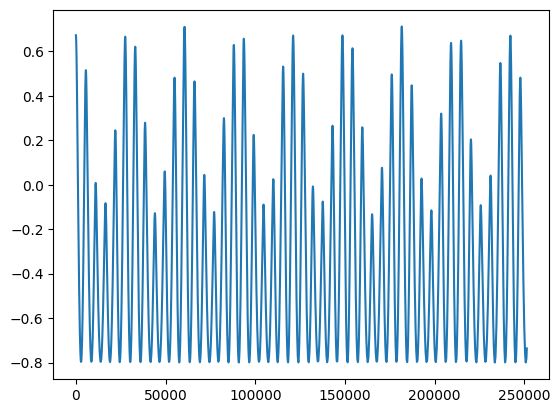

In [349]:
import matplotlib.pyplot as plt
print(trajectories.shape)
plt.plot(list(range(trajectories.shape[2])), trajectories[0, 0, :])
plt.show()

# plt.plot(list(range(trajectories.shape[2])), trajectories[1, 0, :])
# plt.show()

# plt.plot(list(range(trajectories.shape[2])), trajectories[2, 0, :])
# plt.show()

In [211]:
# import matplotlib.pyplot as plt
# print(trajectories.shape)
# plt.plot(list(range(momentums.shape[2])), momentums[0, 0, :])
# plt.show()

# plt.plot(list(range(momentums.shape[2])), momentums[1, 0, :])
# plt.show()

# plt.plot(list(range(momentums.shape[2])), momentums[2, 0, :])
# plt.show()

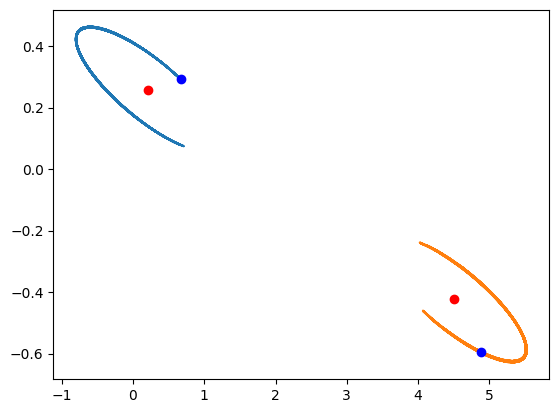

In [350]:
plt.plot(trajectories[0, 0, :], trajectories[1, 0, :], zorder=0)
plt.scatter(n_q[0, 0], n_q[1, 0], c='red', zorder=1)
plt.scatter(h_q[0, 0], h_q[1, 0], c='blue', zorder=1)

plt.plot(trajectories[0, 1, :], trajectories[1, 1, :], zorder=0)
plt.scatter(n_q[0, 1], n_q[1, 1], c='red', zorder=1)
plt.scatter(h_q[0, 1], h_q[1, 1], c='blue', zorder=1)

plt.show()

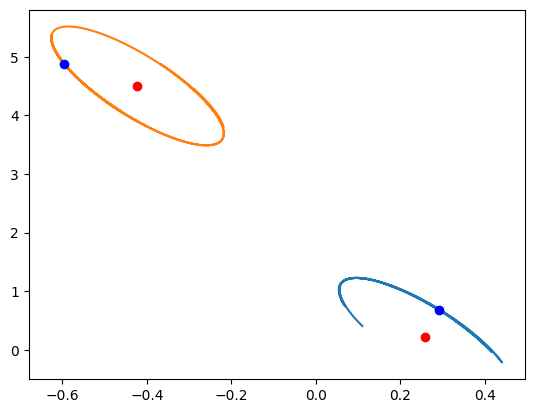

In [290]:
a1 = 1
a2 = 0

plt.plot(trajectories[a1, 0, :], trajectories[a2, 0, :], zorder=0)
plt.scatter(n_q[a1, 0], n_q[a2, 0], c='red', zorder=1)
plt.scatter(h_q[a1, 0], h_q[a2, 0], c='blue', zorder=1)

plt.plot(trajectories[a1, 1, :], trajectories[a2, 1, :], zorder=0)
plt.scatter(n_q[a1, 1], n_q[a2, 1], c='red', zorder=1)
plt.scatter(h_q[a1, 1], h_q[a2, 1], c='blue', zorder=1)

plt.show()

In [128]:
import torch

# Constants
k_spr = 0.1
eps = 1
sigma = 1

def kinetic_energy(h_p, h_m):
    ke = torch.sum(torch.sum(h_p**2, dim=0) / (2 * h_m))
    return ke

def potential_energy(h_q, n_q, h_l, f_c, f_i):
    energy = 0
    k = h_q.shape[1]  # Number of particles
    for i in range(k):
        for j in range(i + 1, k):
            r_ij = torch.norm(h_q[:, i] - h_q[:, j], p=2)
            energy += f_c(r_ij)
        r_i = torch.norm(h_q[:, i] - n_q[:, i], p=2)
        l = h_l[i]
        energy += f_i(r_i, l)
    return energy

def v_t(q, t, e_t):
    return torch.sum(e_t(t) * q)

def f_i(x, l):
    return -k_spr * (x - l) ** 2

def f_c(x):
    return -4 * eps * ((sigma / x) ** 12 - (sigma / x) ** 6)

def e(t):
    return 0  # Consider conservative system initially

def H(h_p, h_q, n_q, h_m, h_l, f_c, f_i, e_t, t):
    return kinetic_energy(h_p, h_m) + potential_energy(h_q, n_q, h_l, f_c, f_i) + v_t(h_q, t, e_t)

# Example usage
# Assuming h_p, h_q, n_q, h_m, h_l are PyTorch tensors with requires_grad=True if gradients are needed

# Example tensor initialization (replace with actual values as needed)
d, k = 3, 2  # dimensions, number of particles
# h_p = torch.randn(d, k, requires_grad=True)
# h_q = torch.randn(d, k, requires_grad=True)
# n_q = torch.randn(d, k, requires_grad=True)
# h_m = torch.tensor([1.0, 1.0], requires_grad=True)
# h_l = torch.tensor([1.0, 1.0], requires_grad=True)
th_p = torch.tensor(h_p, requires_grad=True)# + torch.randn(d, k, requires_grad=True) / 10
th_q = torch.tensor(h_q, requires_grad=True)# + torch.randn(d, k, requires_grad=True) / 10
tn_q = torch.tensor(n_q, requires_grad=False)
th_m = torch.tensor(h_m, requires_grad=False)
th_l = torch.tensor(h_l, requires_grad=False)

# Compute Hamiltonian
hamiltonian = H(th_p, th_q, tn_q, th_m, th_l, f_c, f_i, e, 0)

# Compute gradients
# hamiltonian.backward()

# # Access gradients
# print(th_p.grad)
# print(th_q.grad)
# print(hamiltonian)

# print(torch.autograd.grad(hamiltonian, th_p, retain_graph=True))
# print(torch.autograd.grad(hamiltonian, [th_p, th_q], retain_graph=True))


In [33]:

print(dH_dp(h_p, h_m))

print(dH_dq(h_q, h_m, n_q, h_l))

print(th_p.grad)

print(th_q.grad)
    

[[0. 0.]
 [0. 0.]
 [0. 0.]]
[[-10101748.46351608  10101748.46351608]
 [  2131436.02734135  -2131436.02734135]
 [ -4029701.21392691   4029701.21392691]]
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]], dtype=torch.float64)
tensor([[-10101748.4635,  10101748.4635],
        [  2131436.0273,  -2131436.0273],
        [ -4029701.2139,   4029701.2139]], dtype=torch.float64)


In [125]:

def torch_leapfrog_integration(tq0, tp0, tn_q, th_l, th_m, dt, total_time):
    """
    Perform leapfrog integration.
    """
    steps = int(total_time / dt)
    th_q, th_p = tq0.clone().detach().requires_grad_(True), tp0.clone().detach().requires_grad_(True)
    
    hamiltonian = H(th_p, th_q, tn_q, th_m, th_l, f_c, f_i, e, 0)
    
    # Initialize arrays to store trajectories for plotting
    trajectories = torch.zeros((th_q.shape[0], th_q.shape[1], steps + 1), requires_grad=False)
    trajectories[:, :, 0] = th_q.clone().detach()
    
    momentums = torch.zeros((th_p.shape[0], th_p.shape[1], steps + 1), requires_grad=False)
    momentums[:, :, 0] = th_p.clone().detach()
    
    for step in range(steps):
        if step % (steps // 10) == 0:
            print(f'Step {step} out of {steps}')
        hamiltonian = H(th_p, th_q, tn_q, th_m, th_l, f_c, f_i, e, 0)
        
        th_q_grad = torch.autograd.grad(hamiltonian, th_q, retain_graph=True)[0]
        p_half = (th_p - 0.5 * dt * th_q_grad).clone().detach().requires_grad_(True)
        
        hamiltonian = H(p_half, th_q, tn_q, th_m, th_l, f_c, f_i, e, 0)
        p_half_grad = torch.autograd.grad(hamiltonian, p_half, retain_graph=True)[0]
        th_q = (th_q + dt * p_half_grad).clone().detach().requires_grad_(True)
        
        hamiltonian = H(th_p, th_q, tn_q, th_m, th_l, f_c, f_i, e, 0)
        th_q_grad = torch.autograd.grad(hamiltonian, th_q, retain_graph=True)[0]
        th_p = (p_half - 0.5 * dt * th_q_grad).clone().detach().requires_grad_(True)
        
        # Store positions for plotting
        trajectories[:, :, step + 1] = th_q.clone().detach()
        momentums[:, :, step + 1] = th_p.clone().detach()
    
    return trajectories, momentums

In [129]:

dt = 0.001
total_time = 200*np.pi 

trajectories, momentums = torch_leapfrog_integration(th_q, th_p, tn_q, th_l, th_m, dt, total_time)
# torch_leapfrog_integration(th_q, th_p, tn_q, th_l, th_m, dt, total_time)

Step 0 out of 628318
Step 62831 out of 628318
Step 125662 out of 628318
Step 188493 out of 628318
Step 251324 out of 628318
Step 314155 out of 628318
Step 376986 out of 628318
Step 439817 out of 628318
Step 502648 out of 628318
Step 565479 out of 628318
Step 628310 out of 628318


torch.Size([3, 2, 628319])


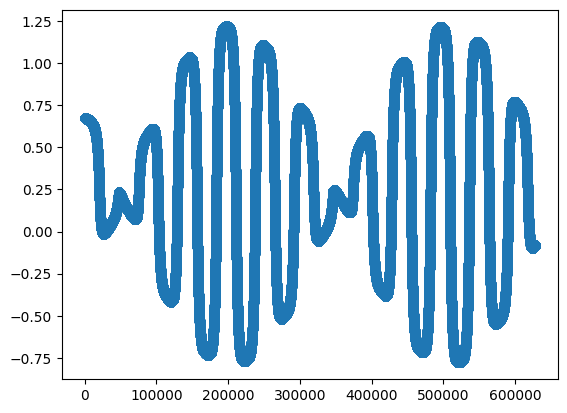

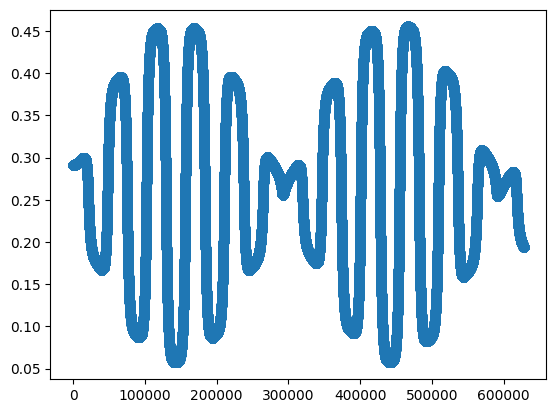

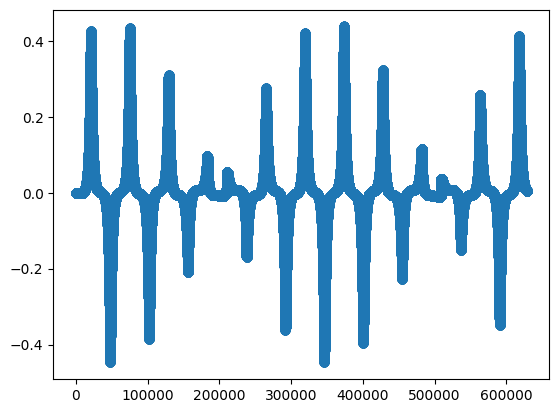

In [130]:
import matplotlib.pyplot as plt
print(trajectories.shape)
plt.scatter(list(range(trajectories.shape[2])), trajectories[0, 0, :])
plt.show()

plt.scatter(list(range(trajectories.shape[2])), trajectories[1, 0, :])
plt.show()

plt.scatter(list(range(momentums.shape[2])), momentums[2, 0, :])
plt.show()

In [4]:

def torch_leapfrog_integration_fix(tq0, tp0, tn_q, th_l, th_m, dt, total_time):
    """
    Perform leapfrog integration.
    """
    steps = int(total_time / dt)
    th_q, th_p = tq0.clone().detach().requires_grad_(True), tp0.clone().detach().requires_grad_(True)
    
    hamiltonian = H(th_p, th_q, tn_q, th_m, th_l, f_c, f_i, e, 0)
    
    # Initialize arrays to store trajectories for plotting
    trajectories = torch.zeros((th_q.shape[0], th_q.shape[1], steps + 1), requires_grad=False)
    trajectories[:, :, 0] = th_q.clone().detach()
    
    momentums = torch.zeros((th_p.shape[0], th_p.shape[1], steps + 1), requires_grad=False)
    momentums[:, :, 0] = th_p.clone().detach()
    
    for step in range(steps):
        if step % (steps // 10) == 0:
            print(f'Step {step} out of {steps}')
        hamiltonian = H(th_p, th_q, tn_q, th_m, th_l, f_c, f_i, e, 0)
        
        th_q_grad = torch.autograd.grad(hamiltonian, th_q, create_graph=True)[0]
        p_half = (th_p - 0.5 * dt * th_q_grad)
        
        hamiltonian = H(p_half, th_q, tn_q, th_m, th_l, f_c, f_i, e, 0)
        p_half_grad = torch.autograd.grad(hamiltonian, p_half, create_graph=True)[0]
        th_q = (th_q + dt * p_half_grad)
        
        hamiltonian = H(th_p, th_q, tn_q, th_m, th_l, f_c, f_i, e, 0)
        th_q_grad = torch.autograd.grad(hamiltonian, th_q, create_graph=True)[0]
        th_p = (p_half - 0.5 * dt * th_q_grad)
        
        # Store positions for plotting
        trajectories[:, :, step + 1] = th_q.clone().detach()
        momentums[:, :, step + 1] = th_p.clone().detach()
    
    return trajectories, momentums

In [132]:

dt = 0.001
total_time = 40*np.pi 

trajectories, momentums = torch_leapfrog_integration_fix(th_q, th_p, tn_q, th_l, th_m, dt, total_time)
# torch_leapfrog_integration(th_q, th_p, tn_q, th_l, th_m, dt, total_time)

Step 0 out of 125663
Step 12566 out of 125663
Step 25132 out of 125663


KeyboardInterrupt: 

: 

In [7]:
import torch
import torch.nn as nn
from torchdiffeq import odeint_adjoint as odeint
from TorchDiffEqPack import odesolve_adjoint_sym12 as odesolve

class HamiltonianSystem(nn.Module):
    def __init__(self, k_spr, eps, sigma):
        super(HamiltonianSystem, self).__init__()
        # Parameters of the potential energy V
        self.k_spr = nn.Parameter(torch.tensor([k_spr], dtype=torch.float32, requires_grad=True))
        self.eps = nn.Parameter(torch.tensor([eps], dtype=torch.float32, requires_grad=True))
        self.sigma = nn.Parameter(torch.tensor([sigma], dtype=torch.float32, requires_grad=True))
        
        self.dim = 3
        
    def forward(self, t, state, tethers, lengths, masses):
        # Unpack the state
        q, p = state[:self.dim, ...], state[self.dim:, ...]
        
        # Derive the system's dynamics from H
        dq_dt = self.dH_dp(p, masses)
        dp_dt = -self.dH_dq(q, tethers, lengths)
        
        return torch.cat([dq_dt, dp_dt], dim=0)


    def df_i(self, x, l):
        return self.k_spr*2*(x - l)

    def df_c(self, x):
        # return 4*eps*(12*sigma**12/x**13 - 6*sigma**6/x**7)
        return -24*self.eps*(2*(self.sigma/x)**12 - (self.sigma/x)**6) / x

    def dH_dp_i(self, h_p, masses, i):
        return h_p[:, i] / masses[i]

    def dH_dq_i(self, h_q, tethers, lengths, i):
        d, k = h_q.shape
        total = torch.zeros(d)
        for j in range(k):
            if i == j:
                continue
            x = h_q[:, i] - h_q[:, j]
            norm_x = torch.norm(x)
            total += x/norm_x * self.df_c(norm_x)
        x = h_q[:, i] - tethers[:, i]
        norm_x = torch.norm(x)
        total += x / norm_x * self.df_i(norm_x, lengths[i])
        return total

    def dH_dp(self, h_p, masses):
        _, k = h_p.shape
        diff_p = torch.zeros_like(h_p)
        for i in range(k):
            diff_p[:, i] = self.dH_dp_i(h_p, masses, i)
        return diff_p

    def dH_dq(self, h_q, tethers, lengths):
        _, k = h_q.shape
        diff_q = torch.zeros_like(h_q)
        for i in range(k):
            diff_q[:, i] = self.dH_dq_i(h_q, tethers, lengths, i)
        return diff_q
    


In [8]:



def molecule_to_torch(hydrogen_list):
    n = len(hydrogen_list)
    precision = torch.float64
    
    h_q = torch.zeros((3, n), dtype=precision)
    h_p = torch.zeros((3, n), dtype=precision)# + 0.01*np.random.rand(3, n)
    n_q = torch.zeros((3, n), dtype=precision)
    h_l = torch.zeros(n)
    h_m = torch.zeros(n)
    
    for i, atom in enumerate(hydrogen_list):
        h_q[:, i] = torch.tensor(atom['H_position'], dtype=precision)
        n_q[:, i] = torch.tensor(atom['connected_atom_position'], dtype=precision)
        h_l[i] = torch.norm(h_q[:, i] - n_q[:, i])
        h_m[i] = 0.1
        
        # h_q[:, i] = h_q[:, i] + 1*np.random.rand(3)
        
        
    # print(h_q, '\n', h_p, '\n', n_q)
    return h_q, h_p, n_q, h_l, h_m

h_q, h_p, n_q, h_l, h_m = molecule_to_torch(molecule_list[10]['H'])

In [5]:
from torch.utils.data import Dataset, DataLoader

class LeapfrogDataset(Dataset):
    def __init__(self, molecules, sequence_length=30000, interval = 1000):
        """
        molecules: A list of dictionaries, each containing 'trajectories', 'momentums', 'n_q', 'h_l', and 'h_m'
        sequence_length: The length of subsequences to sample for training
        """
        self.molecules = molecules
        self.sequence_length = sequence_length
        # Calculate total sequences considering all molecules and the specified sequence length
        self.total_sequences = sum([molecule['trajectories'].shape[2] // sequence_length for molecule in molecules])
        self.interval = interval

    def __len__(self):
        return self.total_sequences

    def __getitem__(self, idx):
        # Determine which molecule this index corresponds to and adjust idx to local index within that molecule
        for molecule in self.molecules:
            if idx < (molecule['trajectories'].shape[2] // self.sequence_length):
                break
            idx -= (molecule['trajectories'].shape[2] // self.sequence_length)
        
        start_idx = idx * self.sequence_length
        end_idx = start_idx + self.sequence_length
        
        # Fetch the trajectory and momentum subsequences and stack them
        trajectories = molecule['trajectories'][:, :, start_idx:end_idx:self.interval]
        momentums = molecule['momentums'][:, :, start_idx:end_idx:self.interval]
        stacked = np.concatenate((trajectories, momentums), axis=0)  
        
        # Convert to PyTorch tensors
        stacked_tensor = torch.from_numpy(stacked).float()
        
        # Parameters are the same for the whole molecule, no need to select a subsequence
        n_q = torch.tensor(molecule['n_q'], dtype=torch.float32)
        h_l = torch.tensor(molecule['h_l'], dtype=torch.float32)
        h_m = torch.tensor(molecule['h_m'], dtype=torch.float32)
        
        return stacked_tensor, n_q, h_l, h_m




In [6]:
#Data generation

k_spr = 10
eps = 0.01
sigma = 3

dt = 0.001
total_time = 240
    
data = []
for idx, molecule in enumerate(molecule_list):
    print(f"{idx+1}/{len(molecule_list)}")
    h_q, h_p, n_q, h_l, h_m = molecule_to_np(molecule['H'])
    trajectories, momentums = leapfrog_integration(h_q, h_p, n_q, h_l, h_m, dt, total_time)
    
    # trajectories = torch.from_numpy(trajectories)
    # momentums = torch.from_numpy(momentums)
    # h_q = torch.from_numpy(h_q)
    # h_p = torch.from_numpy(h_p)
    # n_q = torch.from_numpy(n_q)
    # h_l = torch.from_numpy(h_l)
    # h_m = torch.from_numpy(h_m)
    
    data.append({"trajectories": trajectories, "momentums": momentums, "h_q": h_q, "h_p": h_p, "n_q": n_q, "h_l": h_l, "h_m": h_m})



1/14
2/14
3/14
4/14
5/14
6/14
7/14
8/14
9/14
10/14
11/14
12/14
13/14
14/14


In [115]:
from torch.utils.data import Dataset, DataLoader
import random

class GenerativeDataset(Dataset):
    def __init__(self, molecules, sequence_length=30000, interval = 1000, epoch_sequences = 100, p_perturb = 0.1, q_perturb = 0.1, dt = 0.001):
        """
        molecules: A list of dictionaries, each containing 'trajectories', 'momentums', 'n_q', 'h_l', and 'h_m'
        sequence_length: The length of subsequences to sample for training
        """
        self.molecules = molecules
        self.sequence_length = sequence_length
        self.interval = interval
        self.epoch_sequences = epoch_sequences
        
        self.p_perturb = p_perturb
        self.q_perturb = q_perturb
        self.dt = dt
        self.total_time = self.sequence_length // self.dt

    def __len__(self):
        return self.epoch_sequences

    def __getitem__(self, idx):
        # Determine which molecule this index corresponds to and adjust idx to local index within that molecule
        idx = random.randint(0, len(self.molecules) - 1)
        molecule = self.molecules[idx]
        
        h_q = molecule['h_q'] + self.q_perturb*np.random.rand(*molecule['h_q'].shape)
        h_p = molecule['h_p'] + self.p_perturb*np.random.rand(*molecule['h_p'].shape)
        n_q = molecule['n_q']
        h_l = molecule['h_l']
        h_m = molecule['h_m']
        
        trajectories, momentums = leapfrog_integration(h_q, h_p, n_q, h_l, h_m, self.dt, self.total_time)
        
        # Fetch the trajectory and momentum subsequences and stack them
        trajectories = molecule['trajectories'][:, :, ::self.interval]
        momentums = molecule['momentums'][:, :, ::self.interval]
        stacked = np.concatenate((trajectories, momentums), axis=0)  
        
        # Convert to PyTorch tensors
        stacked_tensor = torch.from_numpy(stacked).float()
        
        # Parameters are the same for the whole molecule, no need to select a subsequence
        n_q = torch.tensor(molecule['n_q'], dtype=torch.float32)
        h_l = torch.tensor(molecule['h_l'], dtype=torch.float32)
        h_m = torch.tensor(molecule['h_m'], dtype=torch.float32)
        
        return stacked_tensor, n_q, h_l, h_m




In [49]:
from TorchDiffEqPack.odesolver import odesolve

#Training

sequence_length = 10
interval = 1

dataset = LeapfrogDataset(data, sequence_length=sequence_length, interval=interval)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

#Hyperparameters
num_epochs = 3

def loss_fn(predicted, true):
    return torch.mean((predicted - true)**2)

model = HamiltonianSystem(9.5, 0.012, 3.5).float()
# optimiser = torch.optim.LBFGS(model.parameters(), lr=1e-3)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)

t_eval = torch.Tensor([i*0.001*interval for i in range(sequence_length//interval)]).float()


for epoch in range(num_epochs):
    for batch_idx, (stacked_input, n_q, h_l, h_m) in enumerate(dataloader):
        optimiser.zero_grad()
        
        stacked_input = stacked_input.squeeze(0)
        n_q = n_q.squeeze(0)
        h_l = h_l.squeeze(0)
        h_m = h_m.squeeze(0)
        
        initial_state = stacked_input.float()[:, :, 0] 
        
        def dynamics_wrapper(t, y):
            return model(t, y, n_q, h_l, h_m)
        
        # state_t = odeint(dynamics_wrapper, initial_state, t_eval, method='dopri5', adjoint_params=list(model.parameters()) + [n_q, h_l, h_m])
        options = {}
        options.update({'method': 'fixedstep_sym12async'})
        options.update({'h': 0.001})
        options.update({'t0': 0.0})
        options.update({'t1': t_eval[-1]})
        options.update({'t_eval':t_eval})
        state_t = odesolve(dynamics_wrapper, initial_state, options=options)
        state_t = state_t.permute(1, 2, 0)
        # Define your target based on the task, e.g., predicting future states, minimizing energy, etc.
        target = stacked_input  # You need to define this based on your specific task
        
        loss = loss_fn(state_t, target)
        loss.backward()
        
        # def closure():
        #     optimiser.zero_grad()
        #     state_t = odesolve(dynamics_wrapper, initial_state, options=options)
        #     state_t = state_t.permute(1, 2, 0)
        #     loss = loss_fn(state_t, target)
        #     loss.backward()
        #     return loss
        # optimiser.step(closure)
        
        optimiser.step()
        
        if batch_idx % 100 == 0:  # Adjust logging frequency as needed
            # Retrieve and format model parameters for printing
            param_str = ', '.join([f'{name}: {param.data}' for name, param in model.named_parameters()])
            print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}, Params: {param_str}")


/tmp/ipykernel_200924/2323273834.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  n_q = torch.tensor(molecule['n_q'], dtype=torch.float32)
/tmp/ipykernel_200924/2323273834.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  h_l = torch.tensor(molecule['h_l'], dtype=torch.float32)
/tmp/ipykernel_200924/2323273834.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  h_m = torch.tensor(molecule['h_m'], dtype=torch.float32)


Epoch 0, Batch 0, Loss: 2.703961001770949e-07, Params: k_spr: tensor([9.4999]), eps: tensor([0.0110]), sigma: tensor([3.4990])
Epoch 0, Batch 100, Loss: 8.500737891381505e-09, Params: k_spr: tensor([9.5060]), eps: tensor([-0.0031]), sigma: tensor([3.4699])
Epoch 0, Batch 200, Loss: 1.6409809622253135e-10, Params: k_spr: tensor([9.5033]), eps: tensor([-0.0007]), sigma: tensor([3.4668])
Epoch 0, Batch 300, Loss: 2.607207227889319e-10, Params: k_spr: tensor([9.5090]), eps: tensor([0.0010]), sigma: tensor([3.4529])
Epoch 0, Batch 400, Loss: 1.002242067116299e-09, Params: k_spr: tensor([9.5142]), eps: tensor([0.0013]), sigma: tensor([3.4519])
Epoch 0, Batch 500, Loss: 1.5581038195766617e-11, Params: k_spr: tensor([9.5171]), eps: tensor([0.0012]), sigma: tensor([3.4519])
Epoch 0, Batch 600, Loss: 1.4104804997583376e-11, Params: k_spr: tensor([9.5212]), eps: tensor([0.0019]), sigma: tensor([3.4520])
Epoch 0, Batch 700, Loss: 8.464584068390568e-12, Params: k_spr: tensor([9.5173]), eps: tensor(

KeyboardInterrupt: 

In [35]:
def dynamics_wrapper(t, y):
    return model(t, y, n_q, h_l, h_m)

sequence_length = 10000
interval = 1
t_eval = torch.Tensor([i*0.001*interval for i in range(sequence_length//interval)]).float()

h_q, h_p, n_q, h_l, h_m = molecule_to_np(molecule_list[10]['H'])

h_q = (h_q)
h_p = (h_p)
n_q = torch.from_numpy(n_q)
h_l = torch.from_numpy(h_l)
h_m = torch.from_numpy(h_m)

stacked = np.concatenate((h_q, h_p), axis=0)  
        
initial_state = torch.from_numpy(stacked).float()
model = HamiltonianSystem(10, 0.01, 3).float()
# model = HamiltonianSystem(9.5000, 0.02, 3.0997).float()
# model = HamiltonianSystem(9.8378, 0.0112, 3.2261).float()


options = {}
options.update({'method': 'fixedstep_sym12async'})
options.update({'h': 0.001})
options.update({'t0': 0.0})
options.update({'t1': t_eval[-1]})
options.update({'t_eval':t_eval})
state_t = odesolve(dynamics_wrapper, initial_state, options=options)
state_t = state_t.permute(1, 2, 0)

In [37]:
class DF_i_Net(nn.Module):
    def __init__(self):
        super(DF_i_Net, self).__init__()
        # Simple architecture: input layer -> hidden layer -> output layer
        self.net = nn.Sequential(
            nn.Linear(2, 64),  # Two inputs: x and l
            nn.Tanh(),
            nn.Linear(64, 64),  # Two inputs: x and l
            nn.Tanh(),
            nn.Linear(64, 1)   # Single output
        )
        
    def forward(self, x, l):
        # Concatenate x and l for the input layer
        input_tensor = torch.cat((x.unsqueeze(-1), l.unsqueeze(-1)), dim=-1)
        return self.net(input_tensor)

class DF_c_Net(nn.Module):
    def __init__(self):
        super(DF_c_Net, self).__init__()
        # Simple architecture: input layer -> hidden layer -> output layer
        self.net = nn.Sequential(
            nn.Linear(1, 64),  # Single input: x
            nn.Tanh(),
            nn.Linear(64, 64),  # Two inputs: x and l
            nn.Tanh(),
            nn.Linear(64, 1)   # Single output
        )
        
    def forward(self, x):
        # Ensure x is the correct shape for the input layer
        x = x.unsqueeze(-1)  # Add an extra dimension for single input
        return self.net(x)

class HamiltonianNODE(nn.Module):
    def __init__(self, df_i_net, df_c_net):
        super(HamiltonianNODE, self).__init__()
        
        self.df_i_net = df_i_net
        self.df_c_net = df_c_net
        
        self.dim = 3
        
    def forward(self, t, state, tethers, lengths, masses):
        # Unpack the state
        q, p = state[:self.dim, ...], state[self.dim:, ...]
        
        # Derive the system's dynamics from H
        dq_dt = self.dH_dp(p, masses)
        dp_dt = -self.dH_dq(q, tethers, lengths)
        
        return torch.cat([dq_dt, dp_dt], dim=0)


    def df_i(self, x, l):
        return self.df_i_net(x, l).squeeze(-1)  # Assuming output needs to be squeezed

    def df_c(self, x):
        return self.df_c_net(x).squeeze(-1)  # Assuming output needs to be squeezed


    def dH_dp_i(self, h_p, masses, i):
        return h_p[:, i] / masses[i]

    def dH_dq_i(self, h_q, tethers, lengths, i):
        d, k = h_q.shape
        total = torch.zeros(d)
        for j in range(k):
            if i == j:
                continue
            x = h_q[:, i] - h_q[:, j]
            norm_x = torch.norm(x)
            total += x/norm_x * self.df_c(norm_x)
        x = h_q[:, i] - tethers[:, i]
        norm_x = torch.norm(x)
        total += x / norm_x * self.df_i(norm_x, lengths[i])
        return total

    def dH_dp(self, h_p, masses):
        _, k = h_p.shape
        diff_p = torch.zeros_like(h_p)
        for i in range(k):
            diff_p[:, i] = self.dH_dp_i(h_p, masses, i)
        return diff_p

    def dH_dq(self, h_q, tethers, lengths):
        _, k = h_q.shape
        diff_q = torch.zeros_like(h_q)
        for i in range(k):
            diff_q[:, i] = self.dH_dq_i(h_q, tethers, lengths, i)
        return diff_q
    


In [66]:
from TorchDiffEqPack.odesolver import odesolve

#Training

sequence_length = 10
interval = 1

dataset = LeapfrogDataset(data, sequence_length=sequence_length, interval=interval)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

#Hyperparameters
num_epochs = 3

def loss_fn(predicted, true):
    return torch.mean((predicted - true)**2)

model = ModHamiltonianNODE().float()
# optimiser = torch.optim.LBFGS(model.parameters(), lr=1e-3)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)

t_eval = torch.Tensor([i*0.001*interval for i in range(sequence_length//interval)]).float()


for epoch in range(num_epochs):
    for batch_idx, (stacked_input, n_q, h_l, h_m) in enumerate(dataloader):
        optimiser.zero_grad()
        
        stacked_input = stacked_input.squeeze(0)
        n_q = n_q.squeeze(0)
        h_l = h_l.squeeze(0)
        h_m = h_m.squeeze(0)
        
        initial_state = stacked_input.float()[:, :, 0] 
        
        def dynamics_wrapper(t, y):
            return model(t, y, n_q, h_l, h_m)
        
        # state_t = odeint(dynamics_wrapper, initial_state, t_eval, method='dopri5', adjoint_params=list(model.parameters()) + [n_q, h_l, h_m])
        options = {}
        options.update({'method': 'fixedstep_sym12async'})
        options.update({'h': 0.001})
        options.update({'t0': 0.0})
        options.update({'t1': t_eval[-1]})
        options.update({'t_eval':t_eval})
        state_t = odesolve(dynamics_wrapper, initial_state, options=options)
        state_t = state_t.permute(1, 2, 0)
        # Define your target based on the task, e.g., predicting future states, minimizing energy, etc.
        target = stacked_input  # You need to define this based on your specific task
        
        loss = loss_fn(state_t, target)
        loss.backward()
        
        # def closure():
        #     optimiser.zero_grad()
        #     state_t = odesolve(dynamics_wrapper, initial_state, options=options)
        #     state_t = state_t.permute(1, 2, 0)
        #     loss = loss_fn(state_t, target)
        #     loss.backward()
        #     return loss
        # optimiser.step(closure)
        
        optimiser.step()
        
        if batch_idx % 100 == 0:  # Adjust logging frequency as needed
            print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}")


/tmp/ipykernel_843/2323273834.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  n_q = torch.tensor(molecule['n_q'], dtype=torch.float32)
/tmp/ipykernel_843/2323273834.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  h_l = torch.tensor(molecule['h_l'], dtype=torch.float32)
/tmp/ipykernel_843/2323273834.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  h_m = torch.tensor(molecule['h_m'], dtype=torch.float32)


Epoch 0, Batch 0, Loss: 6.084549113438698e-07
Epoch 0, Batch 100, Loss: 1.0192554578125623e-09
Epoch 0, Batch 200, Loss: 2.2000667954102937e-09
Epoch 0, Batch 300, Loss: 1.1017330381335455e-09
Epoch 0, Batch 400, Loss: 8.643402438224257e-09
Epoch 0, Batch 500, Loss: 6.225490345457274e-09
Epoch 0, Batch 600, Loss: 2.0238559717000726e-09
Epoch 0, Batch 700, Loss: 1.011711808079907e-11
Epoch 0, Batch 800, Loss: 5.8167470839975977e-11
Epoch 0, Batch 900, Loss: 9.901247183252693e-11
Epoch 0, Batch 1000, Loss: 4.11114031706461e-09
Epoch 0, Batch 1100, Loss: 1.927207143870291e-10
Epoch 0, Batch 1200, Loss: 4.8212998038366095e-09
Epoch 0, Batch 1300, Loss: 9.183436233684006e-10
Epoch 0, Batch 1400, Loss: 1.978683439318729e-09
Epoch 0, Batch 1500, Loss: 5.140734948838599e-09
Epoch 0, Batch 1600, Loss: 1.1395578702888542e-08
Epoch 0, Batch 1700, Loss: 4.2518703224914134e-08
Epoch 0, Batch 1800, Loss: 3.573850937410583e-11
Epoch 0, Batch 1900, Loss: 6.377331995821578e-10
Epoch 0, Batch 2000, Loss

KeyboardInterrupt: 

In [65]:
class DF_i_Net(nn.Module):
    def __init__(self):
        super(DF_i_Net, self).__init__()
        # Simple architecture: input layer -> hidden layer -> output layer
        self.net = nn.Sequential(
            nn.Linear(2, 64),  # Two inputs: x and l
            nn.Tanh(),
            nn.Linear(64, 64),  # Two inputs: x and l
            nn.Tanh(),
            nn.Linear(64, 1)   # Single output
        )
        
    def forward(self, x, l):
        # Concatenate x and l for the input layer
        input_tensor = torch.cat((x.unsqueeze(-1), l.unsqueeze(-1)), dim=-1)
        return self.net(input_tensor)

class DF_c_Net(nn.Module):
    def __init__(self):
        super(DF_c_Net, self).__init__()
        # Simple architecture: input layer -> hidden layer -> output layer
        self.net = nn.Sequential(
            nn.Linear(1, 64),  # Single input: x
            nn.Tanh(),
            nn.Linear(64, 64),  # Two inputs: x and l
            nn.Tanh(),
            nn.Linear(64, 1)   # Single output
        )
        
    def forward(self, x):
        # Ensure x is the correct shape for the input layer
        x = x.unsqueeze(-1)  # Add an extra dimension for single input
        return self.net(x)

class ModHamiltonianNODE(nn.Module):
    def __init__(self):#, df_i_net, df_c_net):
        super(ModHamiltonianNODE, self).__init__()
        
        self.df_i_net = DF_i_Net()
        self.df_c_net = DF_c_Net()
        
        # self.df_i_net = df_i_net
        # self.df_c_net = df_c_net
        
        self.dim = 3
        
    def forward(self, t, state, tethers, lengths, masses):
        # Unpack the state
        q, p = state[:self.dim, ...], state[self.dim:, ...]
        
        # Derive the system's dynamics from H
        dq_dt = self.dH_dp(p, masses)
        dp_dt = -self.dH_dq(q, tethers, lengths)
        
        return torch.cat([dq_dt, dp_dt], dim=0)


    def df_i(self, x, l):
        return self.df_i_net(x, l).squeeze(-1)  # Assuming output needs to be squeezed

    def df_c(self, x):
        return self.df_c_net(x).squeeze(-1)  # Assuming output needs to be squeezed


    def dH_dp(self, h_p, masses):
        diff_p = h_p / masses.unsqueeze(0)
        return diff_p
        

    def dH_dq(self, h_q, tethers, lengths):
        d, k = h_q.shape

        # Compute pairwise differences for df_c, excluding self (i == j)
        h_q_expanded = h_q.unsqueeze(2) - h_q.unsqueeze(1)  # Shape: (d, k, k)
        norms = torch.norm(h_q_expanded, dim=0)  # Compute norms

        # Mask out the diagonal elements for df_c values
        # mask = torch.logical_not(torch.eye(k, dtype=torch.bool, device=h_q.device))  # Shape: (k, k)
        # norms_masked = norms.masked_fill(~mask, float('inf'))  # Replace diagonal with inf to avoid division by zero

        # df_c_values = self.df_c(norms_masked.flatten()).view(k, k)
        # differences_scaled = (h_q_expanded / norms_masked.unsqueeze(0)) * df_c_values.unsqueeze(0)
        # total_c = torch.sum(differences_scaled * mask.unsqueeze(0), dim=2)  # Sum across k, applying mask
        
        
        mask = torch.logical_not(torch.eye(k, dtype=torch.bool, device=h_q.device))  # Shape: (k, k)
        norms_masked = norms.masked_fill(~mask, 1)  # Replace diagonal with one to avoid division by zero

        df_c_values = self.df_c(norms_masked.flatten()).view(k, k)
        differences_scaled = (h_q_expanded / norms_masked.unsqueeze(0)) * df_c_values.unsqueeze(0)
        
        total_c = torch.sum(differences_scaled * mask.unsqueeze(0), dim=2)  # Sum across k, applying mask
        

        # For tethers: directly compute the displacement between each particle and its tether
        differences_tether = h_q - tethers
        norms_tether = torch.norm(differences_tether, dim=0)

        # Prepare inputs for DF_i_Net: Concatenate norms_tether and lengths appropriately
        # Ensure norms_tether and lengths are both 1D tensors of shape (k,)
        # Then, unsqueeze to add the extra dimension needed for concatenation and input into DF_i_Net
        input_df_i = torch.cat((norms_tether.unsqueeze(-1), lengths.unsqueeze(-1)), dim=-1)

        # Assuming df_i (and thereby DF_i_Net) can handle batched inputs
        df_i_values = self.df_i(input_df_i[:, 0], input_df_i[:, 1])  # Adjust based on actual df_i implementation

        # Normalize the differences and scale by df_i_values, ensuring shapes are compatible
        differences_tether_normalized = differences_tether / norms_tether.unsqueeze(0)
        differences_tether_scaled = differences_tether_normalized * df_i_values.unsqueeze(0)

        # Combine the contributions from df_c and df_i operations
        # Ensure total_c calculation is adjusted if needed and is compatible with total_i addition
        total = total_c + differences_tether_scaled

        return total

    


In [18]:
class DF_i_Net(nn.Module):
    def __init__(self):
        super(DF_i_Net, self).__init__()
        # Simple architecture: input layer -> hidden layer -> output layer
        self.net = nn.Sequential(
            nn.Linear(2, 20),  # Two inputs: x and l
            nn.ReLU(),
            nn.Linear(20, 20),  
            nn.ReLU(),
            nn.Linear(20, 20),  
            nn.ReLU(),
            nn.Linear(20, 20),  
            nn.ReLU(),
            nn.Linear(20, 20),  
            nn.ReLU(),
            nn.Linear(20, 20),  
            nn.ReLU(),
            nn.Linear(20, 20),  
            nn.ReLU(),
            nn.Linear(20, 20),  
            nn.ReLU(),
            nn.Linear(20, 20),  
            nn.ReLU(),
            nn.Linear(20, 1)   # Single output
        )
        
    def forward(self, x, l):
        # Concatenate x and l for the input layer
        input_tensor = torch.cat((x.unsqueeze(-1), l.unsqueeze(-1)), dim=-1)
        return self.net(input_tensor)

class DF_c_Net(nn.Module):
    def __init__(self):
        super(DF_c_Net, self).__init__()
        # Simple architecture: input layer -> hidden layer -> output layer
        self.net = nn.Sequential(
            nn.Linear(1, 20),  # Single input: x
            nn.ReLU(),
            nn.Linear(20, 20),  
            nn.ReLU(),
            nn.Linear(20, 20),  
            nn.ReLU(),
            nn.Linear(20, 20),  
            nn.ReLU(),
            nn.Linear(20, 20),  
            nn.ReLU(),
            nn.Linear(20, 20),  
            nn.ReLU(),
            nn.Linear(20, 20),  
            nn.ReLU(),
            nn.Linear(20, 20),  
            nn.ReLU(),
            nn.Linear(20, 20),  
            nn.ReLU(),
            nn.Linear(20, 1)   # Single output
        )
        
    def forward(self, x):
        # Ensure x is the correct shape for the input layer
        x = x.unsqueeze(-1)  # Add an extra dimension for single input
        return self.net(x)

class BatchHamiltonianNODE(nn.Module):
    def __init__(self):#, df_i_net, df_c_net):
        super(BatchHamiltonianNODE, self).__init__()
        
        self.df_i_net = DF_i_Net()
        self.df_c_net = DF_c_Net()
        
        # self.df_i_net = df_i_net
        # self.df_c_net = df_c_net
        
        self.dim = 3
        
    def forward(self, t, state, tethers, lengths, masses):
        # Unpack the state
        q, p = state[:, :self.dim, ...], state[:, self.dim:, ...]
        
        # Derive the system's dynamics from H
        dq_dt = self.dH_dp(p, masses)
        dp_dt = -self.dH_dq(q, tethers, lengths)
        
        return torch.cat([dq_dt, dp_dt], dim=1)


    def df_i(self, x, l):
        return self.df_i_net(x, l).squeeze(-1)  # Assuming output needs to be squeezed

    def df_c(self, x):
        return self.df_c_net(x).squeeze(-1)  # Assuming output needs to be squeezed


    def dH_dp(self, h_p, masses):
        diff_p = h_p / masses.unsqueeze(1)
        return diff_p
        

    def dH_dq(self, h_q, tethers, lengths):
        batch_size, d, k = h_q.shape

        # Compute pairwise differences for df_c, excluding self (i == j)
        h_q_expanded = h_q.unsqueeze(3) - h_q.unsqueeze(2)  # Shape: (batch, d, k, k)
        norms = torch.norm(h_q_expanded, dim=1)  # Shape: (batch, k, k)
        
        
        mask = torch.logical_not(torch.eye(k, dtype=torch.bool, device=h_q.device)).unsqueeze(0).repeat(batch_size, 1, 1)  # Shape: (batch, k, k)
        norms_masked = norms.masked_fill(~mask, 1)  # Replace diagonal with one to avoid division by zero

        df_c_values = self.df_c(norms_masked.flatten()).view(batch_size, k, k)
        differences_scaled = (h_q_expanded / norms_masked.unsqueeze(1)) * df_c_values.unsqueeze(1)
        
        total_c = torch.sum(differences_scaled * mask.unsqueeze(1), dim=3)  # Sum across k, applying mask
        

        # For tethers: directly compute the displacement between each particle and its tether
        differences_tether = h_q - tethers # (batch, d, k)
        norms_tether = torch.norm(differences_tether, dim=1) # (batch, k)
        
        df_i_values = self.df_i(norms_tether, lengths)

        differences_tether_normalized = differences_tether / norms_tether.unsqueeze(1)
        differences_tether_scaled = differences_tether_normalized * df_i_values.unsqueeze(1)

        total = total_c + differences_tether_scaled

        return total

    


In [7]:
import torch
import torch.nn as nn
from torchdiffeq import odeint_adjoint as odeint
from TorchDiffEqPack import odesolve_adjoint_sym12 as odesolve

class BatchHamiltonianSystem(nn.Module):
    def __init__(self, k_spr, eps, sigma):
        super(BatchHamiltonianSystem, self).__init__()
        # Parameters of the potential energy V
        self.k_spr = nn.Parameter(torch.tensor([k_spr], dtype=torch.float32, requires_grad=True))
        self.eps = nn.Parameter(torch.tensor([eps], dtype=torch.float32, requires_grad=True))
        self.sigma = nn.Parameter(torch.tensor([sigma], dtype=torch.float32, requires_grad=True))
        
        self.dim = 3
        
    def forward(self, t, state, tethers, lengths, masses):
        # Unpack the state
        q, p = state[:, :self.dim, ...], state[:, self.dim:, ...]
        
        # Derive the system's dynamics from H
        dq_dt = self.dH_dp(p, masses)
        dp_dt = -self.dH_dq(q, tethers, lengths)
        
        return torch.cat([dq_dt, dp_dt], dim=1)


    def df_i(self, x, l):
        return self.k_spr*2*(x - l)

    def df_c(self, x):
        # return 4*eps*(12*sigma**12/x**13 - 6*sigma**6/x**7)
        return -24*self.eps*(2*(self.sigma/x)**12 - (self.sigma/x)**6) / x

    def dH_dp(self, h_p, masses):
        diff_p = h_p / masses.unsqueeze(1)
        return diff_p
        

    def dH_dq(self, h_q, tethers, lengths):
        batch_size, d, k = h_q.shape

        # Compute pairwise differences for df_c, excluding self (i == j)
        h_q_expanded = h_q.unsqueeze(3) - h_q.unsqueeze(2)  # Shape: (batch, d, k, k)
        norms = torch.norm(h_q_expanded, dim=1)  # Shape: (batch, k, k)
        
        
        mask = torch.logical_not(torch.eye(k, dtype=torch.bool, device=h_q.device)).unsqueeze(0).repeat(batch_size, 1, 1)  # Shape: (batch, k, k)
        norms_masked = norms.masked_fill(~mask, 1)  # Replace diagonal with one to avoid division by zero

        df_c_values = self.df_c(norms_masked.flatten()).view(batch_size, k, k)
        differences_scaled = (h_q_expanded / norms_masked.unsqueeze(1)) * df_c_values.unsqueeze(1)
        
        total_c = torch.sum(differences_scaled * mask.unsqueeze(1), dim=3)  # Sum across k, applying mask
        

        # For tethers: directly compute the displacement between each particle and its tether
        differences_tether = h_q - tethers # (batch, d, k)
        norms_tether = torch.norm(differences_tether, dim=1) # (batch, k)
        
        df_i_values = self.df_i(norms_tether, lengths)

        differences_tether_normalized = differences_tether / norms_tether.unsqueeze(1)
        differences_tether_scaled = differences_tether_normalized * df_i_values.unsqueeze(1)

        total = total_c + differences_tether_scaled

        return total
    


In [8]:
from torch.utils.data import Dataset, DataLoader
import random

class GenerativeDataset(Dataset):
    def __init__(self, molecules, sequence_length=30000, interval = 1000, epoch_sequences = 100, p_perturb = 0.1, q_perturb = 0.1, dt = 0.001):
        """
        molecules: A list of dictionaries, each containing 'trajectories', 'momentums', 'n_q', 'h_l', and 'h_m'
        sequence_length: The length of subsequences to sample for training
        """
        self.molecules = molecules
        self.sequence_length = sequence_length
        self.interval = interval
        self.epoch_sequences = epoch_sequences
        
        self.p_perturb = p_perturb
        self.q_perturb = q_perturb
        self.dt = dt
        self.total_time = self.sequence_length * self.dt

    def __len__(self):
        return self.epoch_sequences

    def __getitem__(self, idx):
        # Determine which molecule this index corresponds to and adjust idx to local index within that molecule
        idx = random.randint(0, len(self.molecules) - 1)
        molecule = self.molecules[idx]
        
        h_q = molecule['h_q'] + self.q_perturb*np.random.rand(*molecule['h_q'].shape)
        h_p = molecule['h_p'] + self.p_perturb*np.random.rand(*molecule['h_p'].shape)
        n_q = molecule['n_q']
        h_l = molecule['h_l']
        h_m = molecule['h_m']
        
        trajectories, momentums = leapfrog_integration(h_q, h_p, n_q, h_l, h_m, self.dt, self.total_time - self.dt)
        
        # Fetch the trajectory and momentum subsequences and stack them
        trajectories = trajectories[:, :, ::self.interval]
        momentums = momentums[:, :, ::self.interval]
        stacked = np.concatenate((trajectories, momentums), axis=0)  
        
        # Convert to PyTorch tensors
        stacked_tensor = torch.from_numpy(stacked).float()
        
        # Parameters are the same for the whole molecule, no need to select a subsequence
        n_q = torch.tensor(molecule['n_q'], dtype=torch.float32)
        h_l = torch.tensor(molecule['h_l'], dtype=torch.float32)
        h_m = torch.tensor(molecule['h_m'], dtype=torch.float32)
        
        return stacked_tensor, n_q, h_l, h_m




In [36]:
from TorchDiffEqPack.odesolver import odesolve

#Training

sequence_length = 10
interval = 1

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")
# device = torch.device("cpu")

# dataset = LeapfrogDataset(data, sequence_length=sequence_length, interval=interval)
dataset = GenerativeDataset(data, sequence_length=sequence_length, interval = interval, epoch_sequences = 100000, p_perturb = 0.5, q_perturb = 0.5, dt = 0.001)
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)

#Hyperparameters
num_epochs = 1000
show_params = False

torch.set_num_threads(10)

# def loss_fn(predicted, true):
#     return torch.mean((predicted - true)**2)

# def loss_fn(predicted, true):
#     k1 = 0.5
#     k2 = 0.5
#     epsilon = 1e-20
    
#     pred = predicted[:, :3, :, :]
#     true = true[:, :3, :, :]
#     pred_norm = torch.norm(pred, dim=1)
#     true_norm = torch.norm(true, dim=1)
#     pred_dot_true = torch.sum(pred * true, dim=1)
    
#     length_diff = torch.sqrt((pred_norm - true_norm)**2 + epsilon)
#     # print(torch.min(pred_norm*true_norm))
#     print(torch.mean(pred_dot_true).item(), torch.mean(pred_norm * true_norm).item())
#     angle_diff = 0.5 * (1 - pred_dot_true / (pred_norm * true_norm))
    
#     spread_result = k1 * length_diff / (pred_norm + true_norm) + k2 * angle_diff
#     result = torch.mean(spread_result)
#     return result

def loss_fn(predicted, true):
    k1 = 0.5
    k2 = 0.5
    epsilon = 1e-20
    
    pred = predicted[:, :3, :, :]
    true = true[:, :3, :, :]
    pred_norm = torch.norm(pred, dim=1)
    true_norm = torch.norm(true, dim=1)
    pred_dot_true = torch.sum(pred * true, dim=1)
    
    length_diff = (pred_norm - true_norm)**2
    # print(torch.min(pred_norm*true_norm))
    # print(torch.mean(pred_dot_true).item(), torch.mean(pred_norm * true_norm).item())
    angle_diff = 0.5 * (1 - pred_dot_true / (pred_norm * true_norm))
    
    spread_result = k1 * length_diff / (pred_norm + true_norm)**2 + k2 * angle_diff**2
    result = torch.mean(spread_result)
    return result

# model = BatchHamiltonianNODE().float().to(device)
model = BatchHamiltonianSystem(10, 0.01, 3).float().to(device)
# optimiser = torch.optim.LBFGS(model.parameters(), lr=10000, max_iter=1000, max_eval=2000, tolerance_change=1e-10, tolerance_grad=1e-10)
optimiser = torch.optim.Adam(model.parameters(), lr=5e-3)
# optimiser = torch.optim.SGD(model.parameters(), lr=10)

t_eval = torch.Tensor([i*0.001*interval for i in range(sequence_length//interval)]).float().to(device)


for epoch in range(num_epochs):
    for batch_idx, (stacked_input, n_q, h_l, h_m) in enumerate(dataloader):
        optimiser.zero_grad()
        
        stacked_input = stacked_input.to(device)
        n_q = n_q.to(device)
        h_l = h_l.to(device)
        h_m = h_m.to(device)
        
        initial_state = stacked_input.float()[:, :, :, 0] 
        
        def dynamics_wrapper(t, y):
            return model(t, y, n_q, h_l, h_m)
            # return y
        
        # state_t = odeint(dynamics_wrapper, initial_state, t_eval, method='dopri5', adjoint_params=list(model.parameters()) + [n_q, h_l, h_m])
        options = {}
        options.update({'method': 'fixedstep_sym12async'})
        options.update({'h': 0.001})
        options.update({'t0': 0.0})
        options.update({'t1': t_eval[-1]})
        options.update({'t_eval':t_eval})
        
        state_t = odesolve(dynamics_wrapper, initial_state, options=options)
        state_t = state_t.permute(1, 2, 3, 0)
        # Define your target based on the task, e.g., predicting future states, minimizing energy, etc.
        target = stacked_input  
        
        
        loss = loss_fn(state_t, state_t)
        print(f"Loss: {loss}")
        loss.backward()
        
        # def closure():
        #     optimiser.zero_grad()
        #     state_t = odesolve(dynamics_wrapper, initial_state, options=options)
        #     state_t = state_t.permute(1, 2, 3, 0)
        #     loss = loss_fn(state_t, target)
        #     loss.backward()
        #     return loss
        # optimiser.step(closure)
        
        optimiser.step()
        
        if batch_idx % 10 == 0:  # Adjust logging frequency as needed
            if not show_params:
                print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}")
            else:
                param_str = ', '.join([f'{name}: {param.data.item()}, {param.grad.item()}' for name, param in model.named_parameters()])
                print(f"Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item()}, Params: {param_str}")


CUDA is available. Using GPU.
23.964996337890625 23.964996337890625
Loss: 5.949907234418172e-16
Epoch 0, Batch 0, Loss: 5.949907234418172e-16
24.651866912841797 24.651866912841797
Loss: 5.977218753011203e-16
24.34848403930664 24.34848403930664
Loss: 6.007416536372003e-16
24.194120407104492 24.194120407104492
Loss: 5.866196027032213e-16
24.320415496826172 24.320415496826172
Loss: 5.904831846734442e-16
24.204570770263672 24.204570770263672
Loss: 5.821121168744076e-16
24.566314697265625 24.566312789916992
Loss: 5.909494763109077e-16
24.15094566345215 24.15094566345215
Loss: 5.876854348486633e-16
24.76634407043457 24.76634407043457
Loss: 5.880851285206489e-16


KeyboardInterrupt: 

In [95]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

CUDA is available. Using GPU.


In [73]:
df_i_net = DF_i_Net()
df_c_net = DF_c_Net()

hnet = HamiltonianNODE(df_i_net, df_c_net)
batchhnet = BatchHamiltonianNODE(df_i_net, df_c_net)


dic = data[0]
trajectories = dic["trajectories"].to(torch.float32)
momentums = dic["momentums"].to(torch.float32)
n_q = dic["n_q"].to(torch.float32)
h_q = trajectories[:, :, 1000]
h_p = momentums[:, :, 1000]
h_l = dic["h_l"].to(torch.float32)
h_m = dic["h_m"].to(torch.float32)

print(hnet.dH_dp(h_p, h_m))
print(hnet.dH_dq(h_q, n_q, h_l))


trajectories = trajectories.unsqueeze(0)
momentums = momentums.unsqueeze(0)
n_q = n_q.unsqueeze(0)
h_q = h_q.unsqueeze(0)
h_p = h_p.unsqueeze(0)
h_l = h_l.unsqueeze(0)
h_m = h_m.unsqueeze(0)

print(modhnet.dH_dp(h_p, h_m))
print(batchhnet.dH_dq(h_q, n_q, h_l))



tensor([[ 2.0485e-05, -5.9325e-04],
        [ 2.9912e-06,  5.0716e-04],
        [-2.5985e-04,  3.7608e-04]])
tensor([[-0.0961,  0.0676],
        [ 0.1131, -0.0068],
        [ 0.0252, -0.0687]], grad_fn=<CopySlices>)
tensor([[[ 2.0485e-05, -5.9325e-04],
         [ 2.9912e-06,  5.0716e-04],
         [-2.5985e-04,  3.7608e-04]]])
tensor([[[-0.0961,  0.0676],
         [ 0.1131, -0.0068],
         [ 0.0252, -0.0687]]], grad_fn=<AddBackward0>)


In [40]:
dic

{'trajectories': tensor([[[-1.5088, -1.5088, -1.5088,  ..., -2.7953, -2.7953, -2.7952],
          [-5.7254, -5.7254, -5.7254,  ..., -6.5066, -6.5067, -6.5067]],
 
         [[-0.5976, -0.5976, -0.5976,  ..., -0.8358, -0.8358, -0.8359],
          [-0.7141, -0.7141, -0.7141,  ..., -1.1621, -1.1621, -1.1621]],
 
         [[-0.1795, -0.1795, -0.1795,  ..., -1.4188, -1.4189, -1.4189],
          [-1.2907, -1.2907, -1.2907,  ..., -1.2748, -1.2749, -1.2749]]],
        dtype=torch.float64),
 'momentums': tensor([[[ 0.0000e+00, -4.4362e-07, -8.8707e-07,  ...,  2.5785e-03,
            2.5787e-03,  2.5789e-03],
          [ 0.0000e+00,  4.4364e-07,  8.8718e-07,  ..., -4.7827e-03,
           -4.7819e-03, -4.7811e-03]],
 
         [[ 0.0000e+00, -1.2261e-08, -2.4534e-08,  ..., -2.8640e-03,
           -2.8638e-03, -2.8636e-03],
          [ 0.0000e+00,  1.2205e-08,  2.4201e-08,  ..., -4.5186e-04,
           -4.5179e-04, -4.5172e-04]],
 
         [[ 0.0000e+00, -1.1680e-07, -2.3311e-07,  ..., -5.9877e-03

In [ ]:
import matplotlib.pyplot as plt

a1 = 1
a2 = 0
for i, dic in enumerate(data):
    print(f"\n{i+1}/{len(data)}")
    trajectories = dic["trajectories"]
    n_q = dic["n_q"]
    h_q = trajectories[:, :, 0]
    plt.plot(trajectories[a1, 0, :], trajectories[a2, 0, :], zorder=0)
    plt.scatter(n_q[a1, 0], n_q[a2, 0], c='red', zorder=1)
    plt.scatter(h_q[a1, 0], h_q[a2, 0], c='blue', zorder=1)

    plt.plot(trajectories[a1, 1, :], trajectories[a2, 1, :], zorder=0)
    plt.scatter(n_q[a1, 1], n_q[a2, 1], c='red', zorder=1)
    plt.scatter(h_q[a1, 1], h_q[a2, 1], c='blue', zorder=1)

    plt.show()


1/14


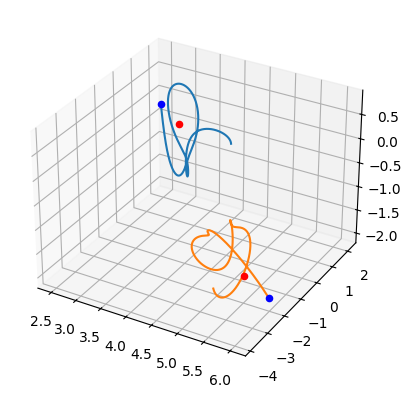


2/14


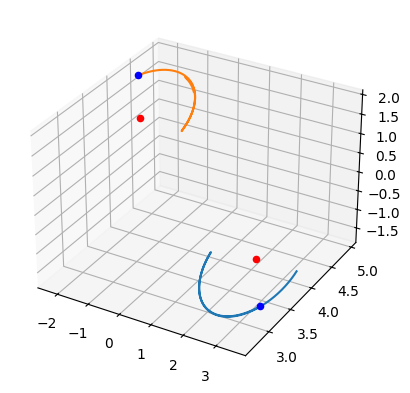


3/14


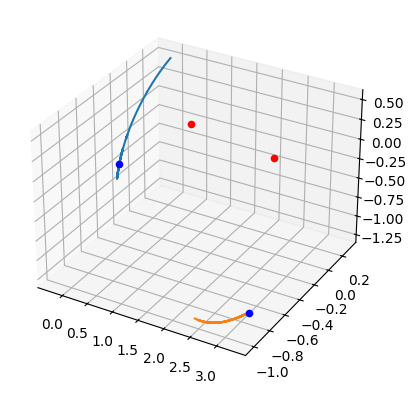


4/14


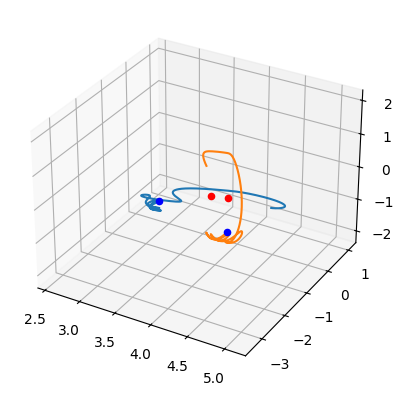


5/14


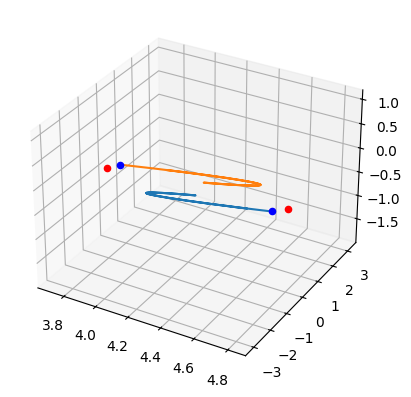


6/14


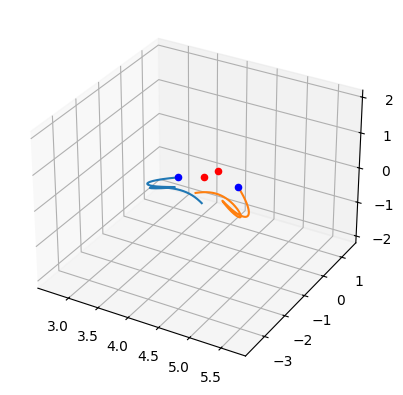


7/14


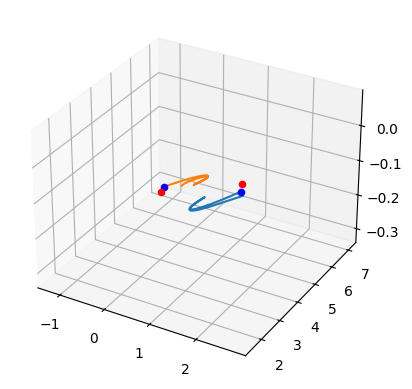


8/14


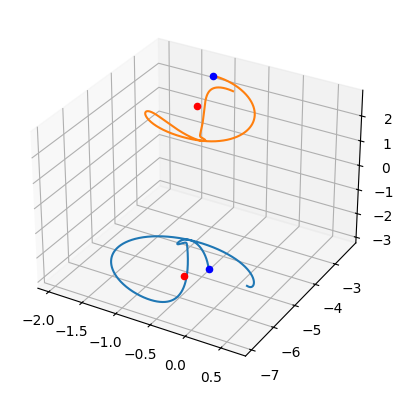


9/14


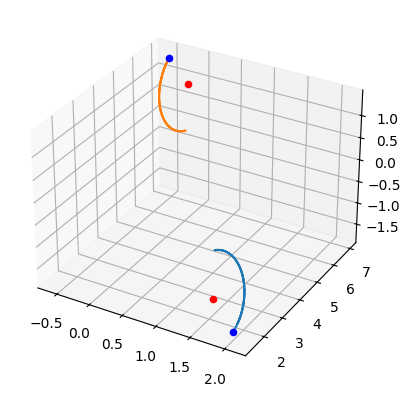


10/14


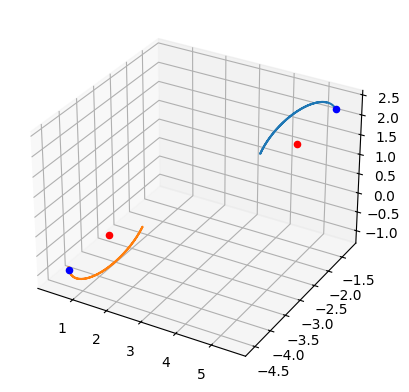


11/14


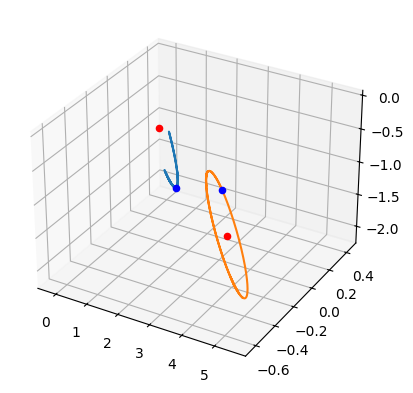


12/14


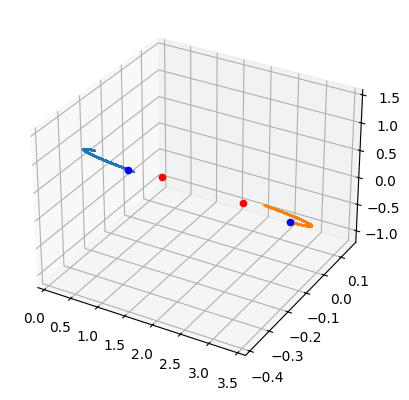


13/14


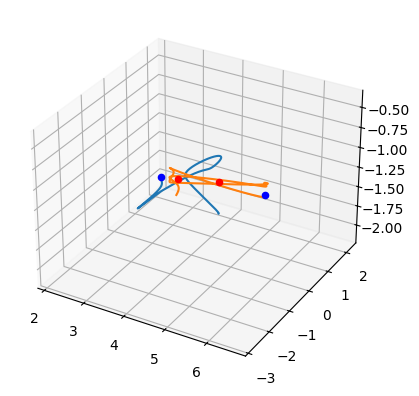


14/14


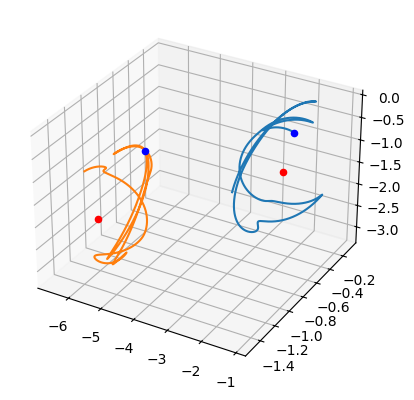

In [34]:
a1 = 0
a2 = 1
a3 = 2

for i, dic in enumerate(data):
    print(f"\n{i+1}/{len(data)}")
    trajectories = dic["trajectories"]
    n_q = dic["n_q"]
    h_q = trajectories[:, :, 0]

    ax = plt.figure().add_subplot(projection='3d')
    ax.plot(trajectories[a1, 0, :], trajectories[a2, 0, :], trajectories[a3, 0, :])
    ax.scatter(n_q[a1, 0], n_q[a2, 0], n_q[a3, 0], c='red')
    ax.scatter(h_q[a1, 0], h_q[a2, 0], h_q[a3, 0], c='blue')

    ax.plot(trajectories[a1, 1, :], trajectories[a2, 1, :], trajectories[a3, 1, :])
    ax.scatter(n_q[a1, 1], n_q[a2, 1], n_q[a3, 1], c='red', zorder=1)
    ax.scatter(h_q[a1, 1], h_q[a2, 1], h_q[a3, 1], c='blue', zorder=1)

    plt.show()

In [24]:
torch.min(trajectories[:, 1, :])

tensor(-6.5628, dtype=torch.float64)